# MPSC Inference and Results lookup
<hr >

> In this notebook we will check our model performance in more details

## Table Of Content
<hr >

> 1. [Imports and Load](#Imports-and-Load)
>     - [Load data](#Load-data)
>     - [Load Model and Predict](#Load-Model-and-Predict)
> 2. [Error-analysis](#Error-analysis)
>     - [a quick look on the top worst predictions](#a-quick-look-on-the-top-worst-predictions)
>     - [which category has worst mae](#which-category-has-worst-mae)
>     - [name wordcloud based on error](#name-wordcloud-based-on-error)
>     - [item_description wordcloud based on error](#item_description-wordcloud-based-on-error)

## Imports and Load
<hr >

In [13]:
import warnings; warnings.filterwarnings('ignore')
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for creating interactive visualizations
import seaborn as sns # data visualization library based on matplotlib
from wordcloud import WordCloud, STOPWORDS
import fasttext # used here for language detection
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers, Model
import joblib

In [2]:
COLAB = "google.colab" in sys.modules
if COLAB:
    print('we are using colab env\n')
    from google.colab import drive
    drive._mount('/content/drive')
    TRAIN_FILE_PATH = '/content/drive/MyDrive/mpsc/train.tsv' # the training file path, change the path if you have it in another dir
else:
    TRAIN_FILE_PATH = './train.tsv' # the training file path, change the path if you have it in another dir

TARGET = 'price'
SEED = 123
MAX_NUM_WORDS_NAME = 40000
MAX_NUM_WORDS_DESC = 80000
MAX_SEQ_LEN_NAME = 20
MAX_SEQ_LEN_DESC = 64

In [3]:
class Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    
class ItemSelector(Transformer):
    def __init__(self, field, fillna_value=None):
        self.field = field
        self.fillna_value = fillna_value
    
    def transform(self, df):
        if self.fillna_value:
            return df[self.field].fillna(self.fillna_value)
        
        return df[self.field]
    
    
class SubCategorySpliter(Transformer):
    def __init__(self, delimiter='/', nth_split=0):
        self.delimiter = delimiter
        self.nth_split = nth_split
        
    def transform(self, series):
        return series.apply(lambda x: x.split(self.delimiter)[self.nth_split])
    
    
class SeriesToArray(Transformer):
    def __init__(self, shape=(-1, 1)):
        self.shape = shape
        
    def transform(self, series):
        return series.values.reshape(self.shape)
    
    
class TextToSeq(Transformer):
    def __init__(
        self,
        num_words=None,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        maxlen=100,
        sparse=True,
        dtype=np.uint32
    ):
        self.num_words = num_words
        self.filters = filters
        self.lower = lower
        self.maxlen = maxlen
        self.sparse = sparse
        self.dtype = dtype
        
    def fit(self, series, y=None):
        self.tokenizer = Tokenizer(num_words=self.num_words, filters=self.filters, lower=self.lower)
        self.tokenizer.fit_on_texts(series)
        
        return self
        
    def transform(self, series):
        seqs = self.tokenizer.texts_to_sequences(series)
        pad_seqs = pad_sequences(seqs, maxlen=self.maxlen, dtype=self.dtype)
        if self.sparse:
            pad_seqs = csr_matrix(pad_seqs)
        
        return pad_seqs
    
    
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, pipes, target, batch_size=1024, train=True, shuffle=True):
        self.df = df
        self.pipes = pipes
        self.target = target
        self.train = train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df)/ self.batch_size))
    
    def __getitem__(self, idx):
        sub_idxs = self.idxs[idx*self.batch_size:(idx+1)*self.batch_size]
        sub_df = self.df.iloc[sub_idxs]
        X, y = self.__data_generation(sub_df)
        
        return X, y

    def on_epoch_end(self):
        self.idxs = np.arange(len(self.df))
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, sub_df):
        X = [pipe.transform(sub_df) for pipe in self.pipes]
        if self.train:
            return X, np.log1p(sub_df[self.target].values)
        
        return X

### Load data

In [4]:
df = pd.read_table(TRAIN_FILE_PATH)
_, df_valid = train_test_split(df, random_state=SEED, train_size=0.8)
pipes = joblib.load('./saved_models/pipes.pkl')
dg_valid = DataGenerator(df=df_valid, pipes=pipes, target=TARGET, batch_size=2**12, shuffle=False)

### Load Model and Predict

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    
class CustomOutputLayer(layers.Layer):
    def __init__(self, min_val, max_val, **kwargs):
        super(CustomOutputLayer, self).__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
        
    def call(self, inputs):
        outputs = tf.sigmoid(inputs)* (self.max_val- self.min_val)+ self.min_val
        output = tf.reduce_mean(outputs, axis=1, keepdims=True)
        
        return output
        
def get_model(seq_1_len, seq_2_len, feats_len, seq_1_max, seq_2_max, out_min_val, out_max_val, use_cuslayer=True):
    seq_1 = layers.Input((seq_1_len,))
    s_1 = layers.Embedding(seq_1_max, 128)(seq_1)
    s_1 = TransformerBlock(128, 4, 128)(s_1)
    s_1 = layers.GlobalAvgPool1D()(s_1)
    
    seq_2 = layers.Input((seq_2_len,))
    s_2 = layers.Embedding(seq_2_max, 128)(seq_2)
    s_2 = TransformerBlock(128, 4, 128)(s_2)
    s_2 = layers.GlobalAvgPool1D()(s_2)
    
    rest_ = layers.Input((feats_len,))
    
    vec = layers.Concatenate(axis=1)([s_1, s_2, layers.Dense(64)(rest_)])
    vec = layers.Dense(64)(vec)
    if use_cuslayer:
        out = CustomOutputLayer(out_min_val, out_max_val)(vec)
    else:
        out = layers.Dense(1)(vec)
        
    model = Model(inputs=[seq_1, seq_2, rest_], outputs=[out])
    
    return model

In [6]:
model_1 = get_model(pipes[0].transform(df_valid.iloc[0:1]).shape[1],
                  pipes[1].transform(df_valid.iloc[0:1]).shape[1],
                  pipes[2].transform(df_valid.iloc[0:1]).shape[1],
                  MAX_NUM_WORDS_NAME,
                  MAX_NUM_WORDS_DESC,
                  0,
                  8
                 )
model_1.load_weights('./saved_models/model_1_weights.hdf')
df_valid['pred_price'] = np.expm1(model_1.predict(dg_valid, verbose=1))

2022-01-18 13:25:03.586292: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


73/73 [==============================] - 241s 3s/step


## Error analysis
<hr >

In [62]:
df_valid['abs_err'] = np.abs(df_valid['price']- df_valid['pred_price'])
df_valid['item_description'] = df_valid['item_description'].fillna('No description yet')
df_valid['category_name'] = df_valid['category_name'].fillna('Other/Other/Other')
df_valid['brand_name'] = df_valid['brand_name'].fillna('Other')
df_valid['main_cat'] = df_valid['category_name'].apply(lambda x: x.split('/', maxsplit=2)[0])
df_valid = df_valid[[col for col in df_valid.columns if not 'price' in col]+ ['price', 'pred_price']].drop('train_id', axis=1)
df_valid

,name,item_condition_id,category_name,brand_name,shipping,item_description,price,pred_price,abs_err,main_cat
933947,On hold for Chelseychu,2,Women/Women's Handbags/Shoulder Bag,Hello Kitty,0,Black faux leather hello kitty satchel comes w...,31.0,39.456593,8.456593,Women
236612,Lace up leggings,2,Women/Pants/Casual Pants,Other,1,Only worn for picture,15.0,9.377182,5.622818,Women
832246,Zipper High Top All Star Converse,3,Women/Shoes/Fashion Sneakers,Converse,0,Size 7 women's Great for your feet! Check out ...,26.0,24.741858,1.258142,Women
343557,Sperry,3,Kids/Girls 2T-5T/Shoes,Other,0,Pink Size 6 toddler Used Very good condition G...,16.0,15.012567,0.987433,Kids
1227445,Lipsense set,1,Beauty/Makeup/Lips,SeneGence,1,Bella color with Glossy gloss and oops remover,50.0,52.261261,2.261261,Beauty
...,...,...,...,...,...,...,...,...,...,...
430921,Hatchimals,1,Kids/Toys/Stuffed Animals & Plush,Other,0,Hatchimals Hatchimals Penguala pink/yellow new...,161.0,135.907272,25.092728,Kids
1140387,Men's Medium Beige Columbia Sweatshirt,3,"Men/Sweats & Hoodies/Sweatshirt, Pullover",Columbia,0,Men's medium beige Columbia sweatshirt - soft ...,14.0,14.574103,0.574103,Men
1469474,Tommy Hilfiger T,3,Women/Tops & Blouses/T-Shirts,Tommy Hilfiger,0,"Small yellow spot next to tag, not noticeable ...",14.0,10.832582,3.167418,Women
195866,Womens Stretchy Plus Size Dress Sz 2XL,1,Women/Dresses/Knee-Length,Other,0,Womens Plus Size Dress Size 2XL New With Tags ...,16.0,13.001413,2.998587,Women


half of our predictions have absulte error less than 10.0


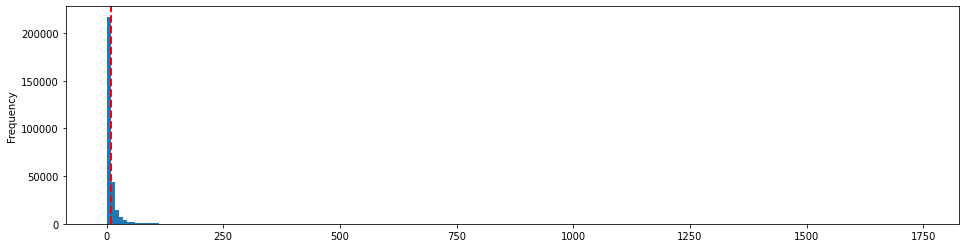

In [36]:
plt.figure(figsize=(16, 4))
df_valid['abs_err'].plot.hist(bins=200)
plt.axvline(df_valid['abs_err'].mean(), color='r', linestyle='dashed', linewidth=2)
mean_abs_err = df_valid['abs_err'].mean()
print(f'half of our predictions have absulte error less than {np.ceil(mean_abs_err)}')

### a quick look on the top worst predictions

In [55]:
df_valid.sort_values('abs_err').tail(25)

,name,item_condition_id,category_name,brand_name,shipping,item_description,price,pred_price,abs_err
1160559,VS Pink Dogs,1,Women/Women's Accessories/Other,Victoria's Secret,0,4 Victoria secret PINK college mini dog ~ NWT ...,906.0,25.288126,880.711874
1036878,Giorgio Armani fabric power,1,Beauty/Makeup/Face,Georgio Armani,0,15 power fabric full size 12- fluid eye tint s...,917.0,27.096090,889.903910
1425704,IPhone 6s Plus,1,Electronics/Cell Phones & Accessories/Cell Pho...,NaN,1,128Gb,941.0,25.915573,915.084427
660189,universal Unlocked IPhone 7 128gigs,1,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,0,Brand new universal Unlocked IPhone 7 128gigs ...,956.0,39.579182,916.420818
1239720,10 [rm] ITunes gift cards,1,Other/Office supplies/Electronics,NaN,1,"10 brand new ITunes gift cards, with [rm] valu...",950.0,32.865372,917.134628
1360222,Louis Vuitton luggage,3,Vintage & Collectibles/Bags and Purses/Luggage,Louis Vuitton,0,"Gently used,",1009.0,76.436684,932.563316
379827,Super Huge Custom Listing,4,Vintage & Collectibles/Collectibles/Other,NaN,1,Up for sale: U.S. 2004-S Wisconsin State Quart...,1050.0,93.271584,956.728416
164527,MONOGRAM SAINT LAURENT WALLET MATELASSÉ,1,Women/Women's Handbags/Shoulder Bag,Saint Laurent,1,"$ 1,550.00 RETAIL MONOGRAM SAINT LAURENT CHAIN...",1525.0,545.462585,979.537415
220581,RESERVED Platinum Engagement Ring 1 TCW,4,Women/Jewelry/Rings,NaN,1,Vintage platinum engagement ring with solitair...,1100.0,119.848366,980.151634
168102,MCM Embellished Bundle,1,Women/Women's Handbags/Shoulder Bag,MCM Worldwide,1,No description yet,1200.0,175.589050,1024.410950


### which category has worst mae

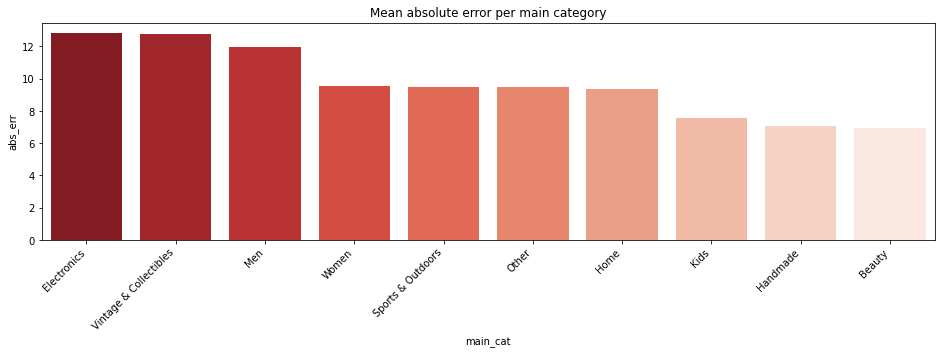

In [66]:
df_ = df_valid.groupby('main_cat')['abs_err'].mean().sort_values(ascending=False).reset_index()
df_.columns = ['main_cat', 'abs_err']
fig, ax = plt.subplots(figsize=(16, 4))
ax.set(title=f'Mean absolute error per main category')
sns.barplot(data=df_, x='main_cat', y='abs_err', palette=sns.color_palette('Reds_r', n_colors=10), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### name wordcloud based on error

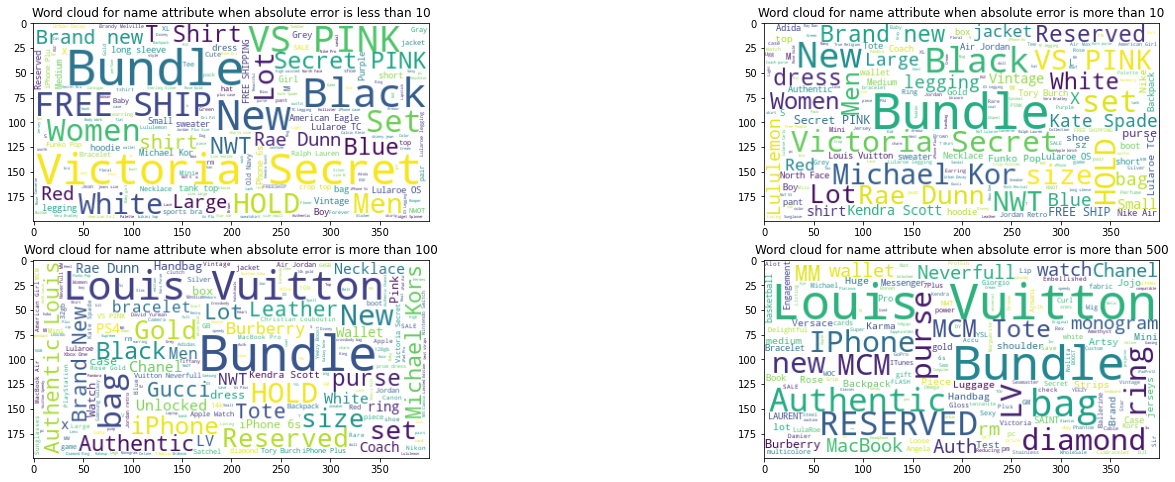

In [54]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
for i, r in enumerate([('l', 10), ('g', 10), ('g', 100), ('g', 500)]):
    if r[0] == 'l':
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_valid.loc[df_valid['abs_err']< r[1], 'name']))
        ax[i//2, i%2].set(title=f'Word cloud for name attribute when absolute error is less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_valid.loc[df_valid['abs_err']> r[1], 'name']))
        ax[i//2, i%2].set(title=f'Word cloud for name attribute when absolute error is more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)

### item_description wordcloud based on error

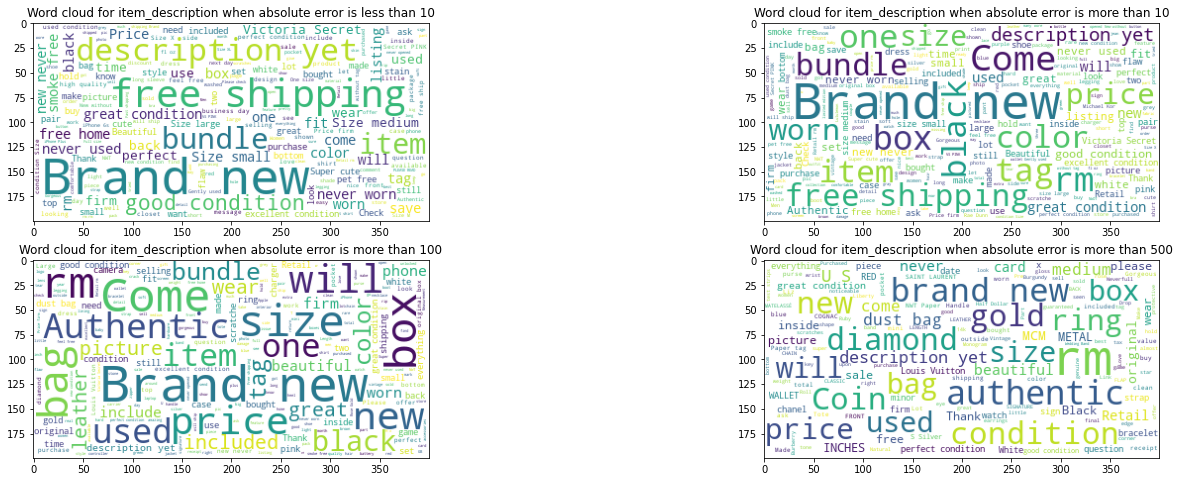

In [58]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
for i, r in enumerate([('l', 10), ('g', 10), ('g', 100), ('g', 500)]):
    if r[0] == 'l':
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_valid.loc[df_valid['abs_err']< r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'Word cloud for item_description when absolute error is less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_valid.loc[df_valid['abs_err']> r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'Word cloud for item_description when absolute error is more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)